In [1]:
# If you want interactive plots
# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
# Change path if necessary, here the cajal repository (direcotry is placed outside the online-neuro) 
sys.path.append(str(Path('../..') / 'cajal'))
sys.path.append(str(Path('..') / 'simulators'))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

from online_neuro.bayessian_optimizer import AskTellOptimizerHistory
from online_neuro import online_learning 
from online_neuro.utils import CustomMinMaxScaler

from trieste.data import Dataset
from trieste.acquisition.function.active_learning import BayesianActiveLearningByDisagreement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste import space

from cajal.nrn import Backend as N
from cajal.nrn import SimulationEnvironment
from cajal.nrn.cells import MRG
from cajal.nrn.monitors import StateMonitor, APMonitor
from cajal.nrn.sources import IsotropicPoint
from cajal.nrn.stimuli import MonophasicPulse
from cajal.units import mm, um, mV, ms, mA, ohm, cm

from simulators.python.problems.cajal_problems import create_mrg
from common.plotting_cajal import (plot_setup_3d, 
                                   plot_progression_AP_2D, 
                                   plot_progression_AP_3D, 
                                   plot_stim_and_block,
                                   plot_waveform)

2025-05-13 11:05:02.329091: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 11:05:02.359994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-13 11:05:02.360023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-13 11:05:02.361020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 11:05:02.366379: I tensorflow/core/platform/cpu_feature_guar

numprocs=1


## Single electrode example


In [4]:
# Time resolution
N.dt = 0.005*ms
# Simulation time
N.tstop = 5*ms

axon_diameter = 5.7*um # um
axon_nodes = 71 # number of axon nodes
# axon model, by default the central node is at origin of the coordinate system
mrg = MRG(diameter=axon_diameter, axonnodes=axon_nodes) 

# extracellular current source
pointsource = IsotropicPoint(x=0, y=0, z=0.5*mm, rhoe=500*ohm*cm)
stim = MonophasicPulse(amp=-1*mA, pw=0.2*ms, delay=0.5*ms)
electrode = pointsource << stim # Assignment

# simulation environment
env = SimulationEnvironment(axons=[mrg], extra_stim=[electrode])

# calculate threshold
thresh = env.find_thresh()
print(f'Threshold is {thresh:.3f} mA')

#From here on we use create_mrg to create the axon model

Threshold is 0.044 mA


# Two electrodes example

In [5]:
# Create the axon model
mrg = create_mrg(diameter=27, length=120, v_init=-80, verbose=True)

# Here we use a fixed stimulation pulse parameters that we want to block
# The stimulation pulse to block start after 2 ms
stim_amp = -1.00 #* mA
stim_pw = 0.50 #* ms
stim_delay = 2.0 #* ms

# Define blocking parameters
block_amp = 0.8 * mA 
block_pw = 0.50 * ms 
block_delay = 2.01 * ms 

# Create stimuli (a stim and block pulse)
stim = MonophasicPulse(amp=stim_amp, pw=stim_pw, delay=stim_delay)
block = MonophasicPulse(amp=block_amp, pw=block_pw, delay=block_delay)

# Create electrodes at both sides of origin (spacing 60 mm) and 1 mm above the nerve
pointsource_stim = IsotropicPoint(x=0 * mm, y=-30 * mm, z=1 * mm, rhoe=500 * ohm * cm)
pointsource_block = IsotropicPoint(x=0 * mm, y=30 * mm, z=1 * mm, rhoe=500 * ohm * cm)

# Assign stimuli to electrodes
electrode_stim = pointsource_stim << stim
electrode_block = pointsource_block << block

# Set up monitors avoid monitoring the edges to eliminate boundary conditions
ap_monitor_end = APMonitor(mrg.node[-5], threshold= -20 * mV)
ap_monitor_start = APMonitor(mrg.node[5], threshold= -20 * mV)
v_rec = StateMonitor(mrg.node, "v")

# Plot the blocking
pointsources = [pointsource_stim, pointsource_block]
labels = ['Stim','Block']


Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


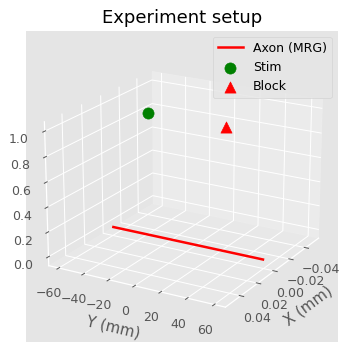

In [6]:
plot_setup_3d(mrg, pointsources, labels,figsize=(4,4), title='Experiment setup',dpi=90)

In [7]:
# Create the simulation environment
env = SimulationEnvironment(
    axons=[mrg],
    extra_stim=[electrode_stim,
                electrode_block], # You can leave the block out to visualize only stim
    monitors=[
        v_rec,
        ap_monitor_end,
        ap_monitor_start]
)

# Run the simulation for a sufficient duration to observe AP propagation
env.run(runtime = 6 * ms, progressbar=True, early_stopping=False)

5.5 ms: 100%|██████████| 1200/1200 [00:03<00:00, 303.37it/s]



Simulation Environment:
  # axons: 1
  # extracellular stimulating electrodes: 2
  dt: 0.005 ms

## Visualizing the nerve conduction overt time and space

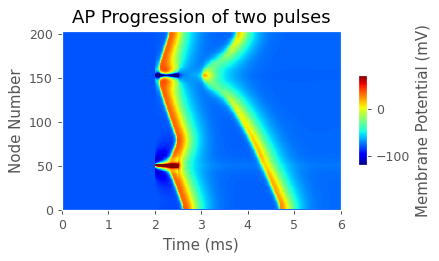

In [8]:
# An example of a failed blocking the AP progression to the right
plot_progression_AP_2D(mrg, v_rec, figsize=(5,3), dpi=90, title="AP Progression of two pulses")

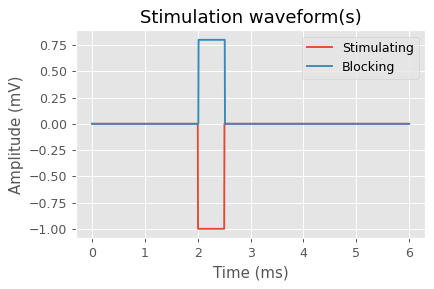

In [9]:
# Replaces the previous plot_stim_and_block
#plot_stim_and_block(stim, block, v_rec, figsize=(4,2), dpi=600)

ax = plot_waveform(stim, v_rec, "Stimulating", figsize=(5,3), dpi=90)
_ = plot_waveform(block, v_rec, "Blocking", ax=ax)



## Performing Gaussian Process based Bayesian Optimization

In [12]:
# These methods checks for action potentials (APs) on both the left and right sides.
from simulators.python.processing.cajal_processing import (nerve_block_condition,
                                                           nerve_block_condition_2,
                                                           nerve_block_condition_3,
                                                           get_ap_directional,
                                                           get_ap_directional_v2,
                                                           detect_block)


In [ ]:
def run_simulation(mrg: MRG, 
                   
                   block_amp: float, 
                   block_pw: float, 
                   block_delay: float, 
                   
                   monitoring_nodes: dict[str,int] = {"AP_start":-5, "AP_end": 5},
                   
                   stim_amp: float = -1.00, #* mA
                   stim_pw: float = 0.50, #* ms
                   stim_delay: float = 2.0, #* ms
                   
                   el_sep: float = 60.0, # mm
                   
                   z_pos: float = 1.0, # mm
                   
                   sim_time: float = 6.0, # ms
                   verbose: bool = True) -> dict[str, APMonitor|StateMonitor]:
    """
    Run the AP blocking simulation with given stimulus parameters.
    
    Parameters:
    - stim_amp: Amplitude of the stimulus pulse (mA)
    - stim_pw: Pulse width of the simtulus pulse (ms)
    - stim_delay: Delay of the stimulus pulse (ms)
    
    General assumptions:
    - Electrodes are placed along the axon (y axis by default).
    - X placement is centered at 0 mm (origin).
    - Z placement is the same for both electrodes.
    
    - Medium is isotropic with a fixed resistivity of 500 ohm*cm.
    
    Returns:
    - ap_count: Number of action potentials reaching the end of the axon.
    """

    if verbose:
        print(f"Configuration: Amplitude {block_amp:.2f} mA, Pulse Width {block_pw:.2f} ms, Delay {block_delay:.2f}")

    # Create stimuli
    stim = MonophasicPulse(amp=stim_amp, pw=stim_pw, delay=stim_delay)
    block = MonophasicPulse(amp=block_amp, pw=block_pw, delay=block_delay)

    # Create electrodes at both ends (set spacing of electrode_separation mm)
    pointsource_stim = IsotropicPoint(x=0 * mm, y=-el_sep/2 * mm, z=z_pos * mm, rhoe=500 * ohm * cm)
    pointsource_block = IsotropicPoint(x=0 * mm, y=el_sep/2 * mm, z=z_pos * mm, rhoe=500 * ohm * cm)

    # Assign stimuli to electrodes
    electrode_stim = pointsource_stim << stim
    electrode_block = pointsource_block << block

    # Set up monitors
    monitors_dict = dict()
    for key, monitoring_node in monitoring_nodes.items():
        monitor = APMonitor(mrg.node[monitoring_node], threshold= -20 * mV)
        monitors_dict[key] = monitor
    
    # ap_monitor_end = APMonitor(mrg.node[-5], threshold= -20 * mV)
    # ap_monitor_start = APMonitor(mrg.node[5], threshold= -20 * mV)
    v_rec = StateMonitor(mrg.node, "v")
    
    monitors_dict['v_rec'] = v_rec
    # Create the simulation environment
    env = SimulationEnvironment(
        axons=[mrg],
        extra_stim=[electrode_stim, electrode_block],
        monitors= list(monitors_dict.values()) + [v_rec]
    )

    # Run the simulation for a sufficient duration to observe AP propagation
    env.run(sim_time * ms, early_stopping=False)
    
    return monitors_dict


def nerve_conduction_blocking_objective(mrg, 
                                        block_amp, block_pw, block_delay,
                                        stim_amp= [-1], stim_pw = [0.5], stim_delay=[2],
                                        ):
    """
    Objective function to optimize AP blocking
    """
    # TODO improve this part
    if len(block_amp) != len(stim_amp):
        stim_amp = [stim_amp[0]]*len(block_amp)
        stim_pw = [stim_pw[0]]*len(block_amp)
        stim_delay = [stim_delay[0]]*len(block_amp)
        
                    
    #block_amp, block_pw, block_delay = params[:, 0], params[:, 1], params[:, 2]
    
    observations = []
    default_dict = {
        'stim_blocked': np.nan,
        'stim_generated': np.nan
    }
    
    for s_amp, s_pw, s_delay, b_amp, b_pw, b_delay in zip(stim_amp, stim_pw, stim_delay,
                                                          block_amp, block_pw, block_delay):
        # Run the simulation with given parameters
        try:
            monitors_dict = run_simulation(mrg = mrg,
                                           stim_amp = s_amp,
                                           stim_pw = s_pw,
                                           stim_delay = s_delay,
                                           block_amp = b_amp,
                                           block_pw = b_pw,
                                           block_delay = b_delay)
            
            # observation = nerve_block_condition(monitors_dict["AP_start"],
            #                                     monitors_dict["AP_end"]
            #                                 )
            v_rec = monitors_dict['v_rec']
            
            v_binary = v_rec.v > -0.0 # Assuming some threshold
            
            # ap_lines = get_ap_directional_v2(v_binary,
            #                                  min_nodes_for_ap_start=1,
            #                                  y_propagation_threshold=10)
            
            ap_lines = get_ap_directional(v_binary, min_nodes_for_ap_start=1, y_propagation_threshold=10)
            

            ap_evaluation = detect_block(stim_delay=s_delay,
                                         ap_directional_lines=ap_lines,
                                         v_rec = v_rec,
                                         block_position = 'downward')
            print("   ")
            print(ap_evaluation)
            plot_directional_aps(ap_directional_lines=ap_lines, v_bool=v_binary)

            
            observations.append(ap_evaluation)

        except Exception as e:
            print(e)
            print(f"Simulation failed with amp={b_amp}, pulse width={b_pw}, delay={b_delay}: {e}")
            observations.append(default_dict)  

    return observations #np.array(observations).reshape(-1, 1)


In [ ]:
def plot_directional_aps(ap_directional_lines, v_bool, figsize=(8,3)):
    # Plotting (same as v2's plotting)
    fig, ax = plt.subplots(figsize=figsize)
    ax.matshow(v_bool, aspect='auto', cmap='viridis', origin='upper')
    ax.set_xlabel("Time (pixels)")
    ax.set_ylabel("Node (pixels)")
    ax.set_title("AP Directional Lines")

    colors = ['red', 'deepskyblue', 'lime', 'orange', 'magenta', 'cyan', 'yellow', 'black']
    for i, ap_data in enumerate(ap_directional_lines):
        label_prefix = f'AP {i+1}'
        up_coords = ap_data["upward_line_coords"]
        down_coords = ap_data["downward_line_coords"]
        hull_edges = ap_data['hull_coordinates']
        color_up = colors[i % len(colors)]
        color_down_idx_offset = 3 
        if len(colors) <= color_down_idx_offset: color_down_idx_offset = 1
        color_down = colors[(i + color_down_idx_offset) % len(colors)]
        if color_down == color_up: color_down = colors[(i + color_down_idx_offset + 1) % len(colors)]

        plot_kwargs_up = {'linestyle': '-', 'marker': 'o', 'markersize': 4, 'alpha': 0.9}
        plot_kwargs_down = {'linestyle': '--', 'marker': 'x', 'markersize': 5, 'alpha': 0.9}

        xs, ys = hull_edges[:,1], hull_edges[:,0]
        ax.scatter(xs.tolist(), ys.tolist(),size=4, c='r')
        if up_coords:
            (x1u, y1u), (x2u, y2u) = up_coords
            ax.plot([x1u, x2u], [y1u, y2u], color=color_up, linewidth=2,
                    label=f'{label_prefix} Upward' if i < 3 else None, **plot_kwargs_up)

        if down_coords:
            (x1d, y1d), (x2d, y2d) = down_coords
            ax.plot([x1d, x2d], [y1d, y2d], color=color_down, linewidth=2,
                    label=f'{label_prefix} Downward' if i < 3 else None, **plot_kwargs_down)
        
        if not up_coords and not down_coords: 
                ax.plot(ap_data["component_start_time"], (ap_data["min_y_at_start"] + ap_data["max_y_at_start"])/2, 
                    marker='s', color='gray', markersize=6, linestyle='None',
                    label=f'{label_prefix} Start (No Sig. Y-Prop.)' if i<3 else None)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if by_label:
        ax.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray')
    plt.tight_layout(rect=(0, 0, 0.78, 1))
    plt.show()

    print(f"\nDetected {len(ap_directional_lines)} APs with directional line coordinates (v3):")
    for i, ap_data in enumerate(ap_directional_lines):
        print(f"  AP {i+1} (Label: {ap_data['label']}):")
        print(f"    Component Start Time: {ap_data['component_start_time']}, Overall Component End Time: {ap_data['component_end_time']}")
        print(f"    Initial Y Extent: Min={ap_data['min_y_at_start']}, Max={ap_data['max_y_at_start']}")
        up_line = ap_data['upward_line_coords']
        down_line = ap_data['downward_line_coords']
        
        up_str = 'None (No significant upward propagation detected)'
        if up_line:
            up_str = f"from ({up_line[0][0]},{up_line[0][1]}) to ({up_line[1][0]},{up_line[1][1]}) (Line End Time: {up_line[1][0]})"
        print(f"    Upward Line: {up_str}")
        
        down_str = 'None (No significant downward propagation detected)'
        if down_line:
            down_str = f"from ({down_line[0][0]},{down_line[0][1]}) to ({down_line[1][0]},{down_line[1][1]}) (Line End Time: {down_line[1][0]})"
        print(f"    Downward Line: {down_str}")

In [42]:
from scipy.spatial import ConvexHull
from scipy import ndimage

def get_ap_directional(binary_array, min_nodes_for_ap_start=1, y_propagation_threshold=1):
    """
    Identifies APs and provides line coordinates for "upward" propagation from its
    initial min-y extent and "downward" propagation from its initial max-y extent.
    Lines are only generated if significant y-propagation occurs in that direction.
    Lines extend to the end of any plateau at the maximum y-excursion for that specific front's envelope.

    Args:
        binary_array (np.array): 2D boolean or int (0/1) array.
        min_nodes_for_ap_start (int): Minimum y-span at AP start.
        y_propagation_threshold (int): Min change in y for propagation to be considered significant.

    Returns:
        list: Dictionaries for each AP:
            - 'label', 'component_start_time', 'component_end_time' (overall component)
            - 'y_span_at_start', 'min_y_at_start', 'max_y_at_start'
            - 'upward_line_coords' (tuple of tuples or None): ((x_start, y_start_min), (x_end_up_plateau, y_extreme_of_min_envelope))
            - 'downward_line_coords' (tuple of tuples or None): ((x_start, y_start_max), (x_end_down_plateau, y_extreme_of_max_envelope))
    """
    if not isinstance(binary_array, np.ndarray) or binary_array.ndim != 2:
        raise ValueError("binary_array must be a 2D NumPy array.")
    
    if binary_array.dtype == bool:
        binary_array = binary_array.astype(np.int8)

    labeled_array, num_features = ndimage.label(binary_array)
    if num_features == 0: return []

    detected_ap_lines_data = []

    for label_idx in range(1, num_features + 1):
        coords_comp = np.argwhere(labeled_array == label_idx)
        if coords_comp.shape[0] == 0: continue
        
        if coords_comp.shape[0] < 3:
            continue
        
        hull = ConvexHull(coords_comp)
        hull_coords = coords_comp[hull.vertices]
        
        t_start_comp = np.min(coords_comp[:, 1])
        t_end_comp_overall = np.max(coords_comp[:, 1])

        y_nodes_at_t_start_arr = np.unique(coords_comp[coords_comp[:, 1] == t_start_comp, 0])
        y_span_at_start = len(y_nodes_at_t_start_arr)

        if y_span_at_start < min_nodes_for_ap_start: continue

        min_y_at_start = np.min(y_nodes_at_t_start_arr)
        max_y_at_start = np.max(y_nodes_at_t_start_arr)

        min_y_envelope_points = []
        max_y_envelope_points = []
        
        for t_current in range(t_start_comp, t_end_comp_overall + 1):
            y_nodes_at_t_current = np.unique(coords_comp[coords_comp[:, 1] == t_current, 0])
            if y_nodes_at_t_current.size > 0:
                min_y_envelope_points.append((t_current, np.min(y_nodes_at_t_current)))
                max_y_envelope_points.append((t_current, np.max(y_nodes_at_t_current)))
        
        upward_line_coords = None
        downward_line_coords = None

        # Determine Upward Line
        if min_y_envelope_points:
            # Find the most extreme y-value achieved by the min_y_envelope itself
            y_extreme_min_of_min_envelope = min(y_val for t, y_val in min_y_envelope_points)
            
            propagated_upward_significantly = (y_extreme_min_of_min_envelope < min_y_at_start - y_propagation_threshold)
            
            if propagated_upward_significantly:
                # Find the last time this extreme y-value was achieved by the min_y_envelope
                t_end_plateau_up = t_start_comp 
                for t_env, y_env in reversed(min_y_envelope_points):
                    if y_env == y_extreme_min_of_min_envelope:
                        t_end_plateau_up = t_env
                        break
                upward_line_coords = ((t_start_comp, min_y_at_start), (t_end_plateau_up, y_extreme_min_of_min_envelope))
                
        # Determine Downward Line
        if max_y_envelope_points:
            # Find the most extreme y-value achieved by the max_y_envelope itself
            y_extreme_max_of_max_envelope = max(y_val for t, y_val in max_y_envelope_points)

            propagated_downward_significantly = (y_extreme_max_of_max_envelope > max_y_at_start + y_propagation_threshold)

            if propagated_downward_significantly:
                # Find the last time this extreme y-value was achieved by the max_y_envelope
                t_end_plateau_down = t_start_comp
                for t_env, y_env in reversed(max_y_envelope_points):
                    if y_env == y_extreme_max_of_max_envelope:
                        t_end_plateau_down = t_env
                        break
                downward_line_coords = ((t_start_comp, max_y_at_start), (t_end_plateau_down, y_extreme_max_of_max_envelope))
        
        detected_ap_lines_data.append({
            "label": label_idx,
            "total_of_features": num_features,
            "hull_coordinates": hull_coords,
            "component_start_time": t_start_comp,
            "component_end_time": t_end_comp_overall, 
            "upward_line_coords": upward_line_coords,
            "downward_line_coords": downward_line_coords,
            "y_span_at_start": y_span_at_start,
            "min_y_at_start": min_y_at_start,
            "max_y_at_start": max_y_at_start,
        })

    detected_ap_lines_data.sort(key=lambda ap: ap["component_start_time"])
    return detected_ap_lines_data

In [43]:
ap_lines = get_ap_directional(v_binary, min_nodes_for_ap_start=1, y_propagation_threshold=10)

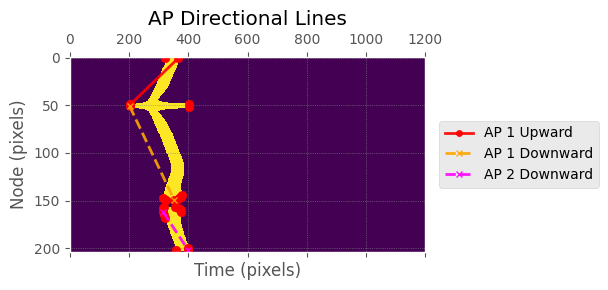


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 202, Overall Component End Time: 402
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (202,50) to (365,1) (Line End Time: 365)
    Downward Line: from (202,51) to (352,149) (Line End Time: 352)
  AP 2 (Label: 2):
    Component Start Time: 315, Overall Component End Time: 400
    Initial Y Extent: Min=159, Max=162
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (315,162) to (400,202) (Line End Time: 400)


In [44]:
plot_directional_aps(ap_lines, v_binary)

In [22]:
# Define parameter bounds
lb = [-4.00, 0.05, 0.05]  # Lower bounds for [block_amp, block_pw, block_delay]
ub = [4.00, 3.00, 3.2]  # Upper bounds

# Initialize scaler
scaler = CustomMinMaxScaler(feature_min=lb, 
                            feature_max=ub,
                            output_range=(-1, 1))

# Define search space
search_space = space.Box(lower=[-1, -1, -1], upper=[1, 1, 1])

# Generate initial amount of samples 
init_samples = 10
qp_minmax = search_space.sample(init_samples).numpy()
qp = scaler.inverse_transform(qp_minmax)

# Set desired diameter, length and v_init
mrg = create_mrg(diameter=27,
                 length=120, 
                 v_init=-80, 
                 verbose=True)

Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


Configuration: Amplitude -0.52 mA, Pulse Width 1.02 ms, Delay 2.73


5.5 ms: 100%|██████████| 1200/1200 [00:16<00:00, 73.44it/s]


AP detected with a difference of [-0.01]
   
{'stim_blocked': False, 'stim_generated': True}


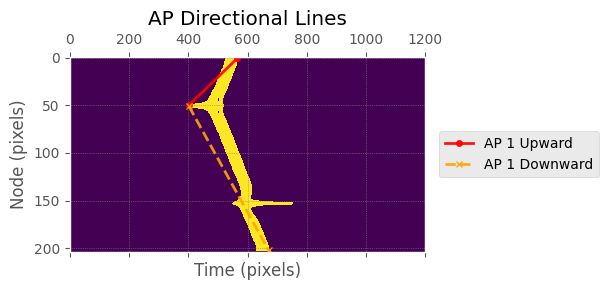


Detected 1 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 750
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (565,1) (Line End Time: 565)
    Downward Line: from (402,51) to (671,202) (Line End Time: 671)
Configuration: Amplitude -2.82 mA, Pulse Width 0.06 ms, Delay 1.75


5.5 ms: 100%|██████████| 1200/1200 [00:15<00:00, 77.75it/s]


AP detected with a difference of [0.15]
   
{'stim_blocked': False, 'stim_generated': True}


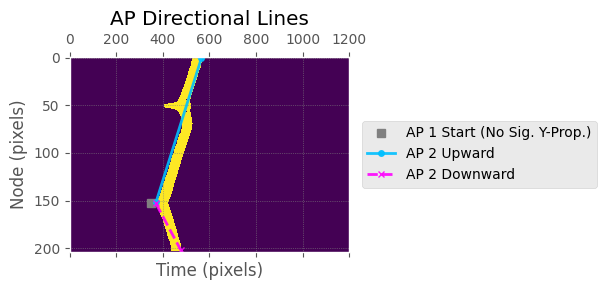


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 2):
    Component Start Time: 350, Overall Component End Time: 364
    Initial Y Extent: Min=152, Max=153
    Upward Line: None (No significant upward propagation detected)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 1):
    Component Start Time: 370, Overall Component End Time: 565
    Initial Y Extent: Min=152, Max=153
    Upward Line: from (370,152) to (565,1) (Line End Time: 565)
    Downward Line: from (370,153) to (477,202) (Line End Time: 477)
Configuration: Amplitude 3.62 mA, Pulse Width 0.10 ms, Delay 3.20


5.5 ms: 100%|██████████| 1200/1200 [00:15<00:00, 77.36it/s]


AP detected with a difference of [-0.01]
   
{'stim_blocked': False, 'stim_generated': True}


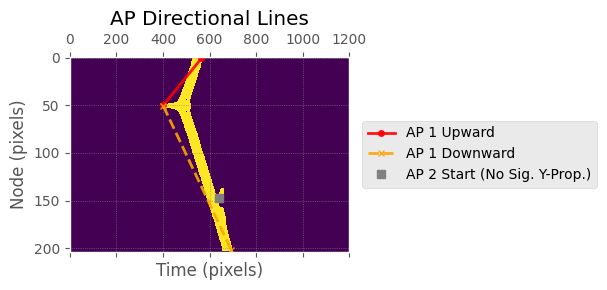


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 694
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (565,1) (Line End Time: 565)
    Downward Line: from (402,51) to (694,202) (Line End Time: 694)
  AP 2 (Label: 2):
    Component Start Time: 640, Overall Component End Time: 661
    Initial Y Extent: Min=144, Max=150
    Upward Line: None (No significant upward propagation detected)
    Downward Line: None (No significant downward propagation detected)
Configuration: Amplitude 1.33 mA, Pulse Width 1.19 ms, Delay 1.85


5.5 ms: 100%|██████████| 1200/1200 [00:15<00:00, 75.78it/s]


AP detected with a difference of [0.1]
   
{'stim_blocked': False, 'stim_generated': True}


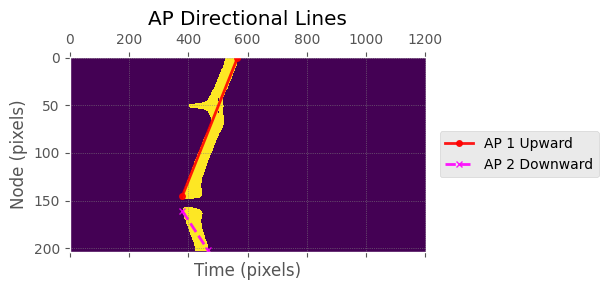


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 380, Overall Component End Time: 565
    Initial Y Extent: Min=145, Max=146
    Upward Line: from (380,145) to (565,1) (Line End Time: 565)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 2):
    Component Start Time: 380, Overall Component End Time: 466
    Initial Y Extent: Min=159, Max=161
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (380,161) to (466,202) (Line End Time: 466)
Configuration: Amplitude -2.14 mA, Pulse Width 0.23 ms, Delay 3.00


5.5 ms: 100%|██████████| 1200/1200 [00:15<00:00, 78.09it/s]


AP detected with a difference of [-0.01]
   
{'stim_blocked': False, 'stim_generated': True}


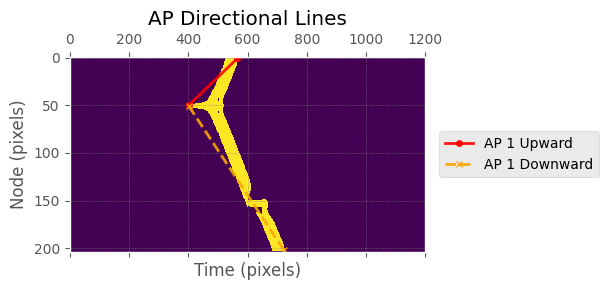


Detected 1 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 723
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (565,1) (Line End Time: 565)
    Downward Line: from (402,51) to (723,202) (Line End Time: 723)
Configuration: Amplitude -1.39 mA, Pulse Width 2.72 ms, Delay 3.00


5.5 ms: 100%|██████████| 1200/1200 [00:15<00:00, 75.64it/s]


AP detected with a difference of [-0.01]
   
{'stim_blocked': False, 'stim_generated': True}


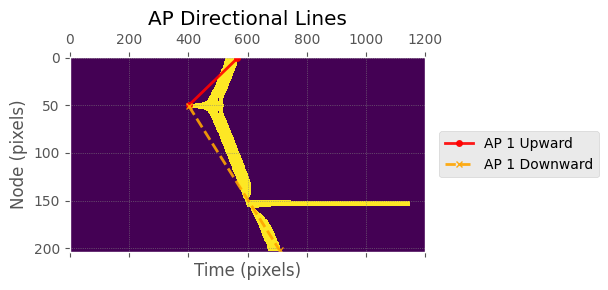


Detected 1 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 1147
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (565,1) (Line End Time: 565)
    Downward Line: from (402,51) to (708,202) (Line End Time: 708)
Configuration: Amplitude 3.83 mA, Pulse Width 2.30 ms, Delay 1.47


5.5 ms: 100%|██████████| 1200/1200 [00:15<00:00, 77.14it/s]


AP detected with a difference of [0.525]
   
{'stim_blocked': False, 'stim_generated': True}


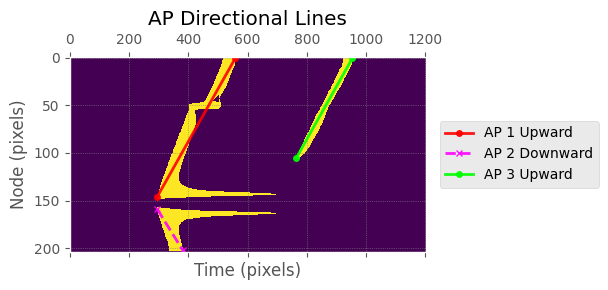


Detected 3 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 295, Overall Component End Time: 693
    Initial Y Extent: Min=146, Max=148
    Upward Line: from (295,146) to (558,1) (Line End Time: 558)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 3):
    Component Start Time: 295, Overall Component End Time: 695
    Initial Y Extent: Min=157, Max=159
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (295,159) to (381,202) (Line End Time: 381)
  AP 3 (Label: 2):
    Component Start Time: 765, Overall Component End Time: 953
    Initial Y Extent: Min=105, Max=105
    Upward Line: from (765,105) to (953,1) (Line End Time: 953)
    Downward Line: None (No significant downward propagation detected)
Configuration: Amplitude -2.64 mA, Pulse Width 2.36 ms, Delay 0.70


5.5 ms: 100%|██████████| 1200/1200 [00:16<00:00, 74.64it/s]


   
{'stim_blocked': False, 'stim_generated': False}


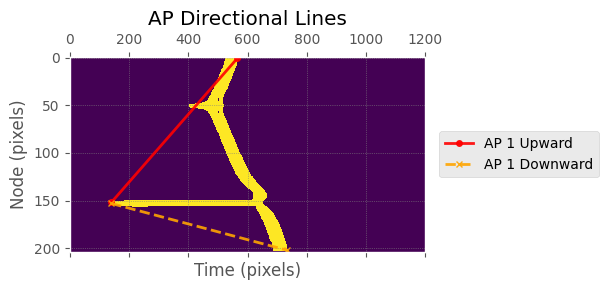


Detected 1 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 140, Overall Component End Time: 733
    Initial Y Extent: Min=152, Max=153
    Upward Line: from (140,152) to (565,1) (Line End Time: 565)
    Downward Line: from (140,153) to (733,202) (Line End Time: 733)
Configuration: Amplitude 2.43 mA, Pulse Width 1.95 ms, Delay 0.62


5.5 ms: 100%|██████████| 1200/1200 [00:16<00:00, 74.49it/s]


   
{'stim_blocked': False, 'stim_generated': False}


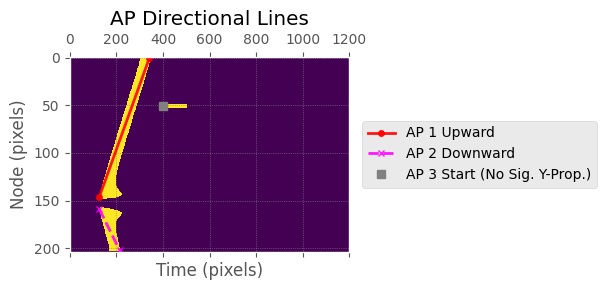


Detected 3 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 127, Overall Component End Time: 341
    Initial Y Extent: Min=146, Max=147
    Upward Line: from (127,146) to (341,1) (Line End Time: 341)
    Downward Line: None (No significant downward propagation detected)
  AP 2 (Label: 3):
    Component Start Time: 127, Overall Component End Time: 221
    Initial Y Extent: Min=158, Max=159
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (127,159) to (214,202) (Line End Time: 214)
  AP 3 (Label: 2):
    Component Start Time: 402, Overall Component End Time: 502
    Initial Y Extent: Min=50, Max=51
    Upward Line: None (No significant upward propagation detected)
    Downward Line: None (No significant downward propagation detected)
Configuration: Amplitude 1.06 mA, Pulse Width 1.85 ms, Delay 2.49


5.5 ms: 100%|██████████| 1200/1200 [00:15<00:00, 77.73it/s]


AP detected with a difference of [-0.01]
   
{'stim_blocked': True, 'stim_generated': True}


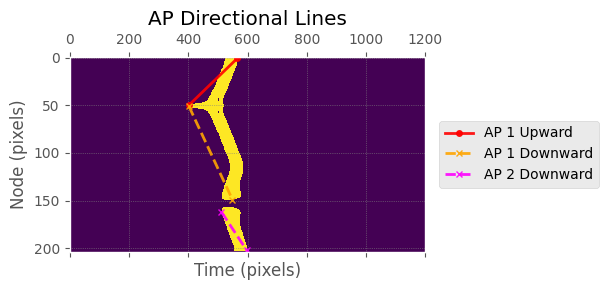


Detected 2 APs with directional line coordinates (v3):
  AP 1 (Label: 1):
    Component Start Time: 402, Overall Component End Time: 583
    Initial Y Extent: Min=50, Max=51
    Upward Line: from (402,50) to (565,1) (Line End Time: 565)
    Downward Line: from (402,51) to (549,149) (Line End Time: 549)
  AP 2 (Label: 2):
    Component Start Time: 512, Overall Component End Time: 597
    Initial Y Extent: Min=159, Max=162
    Upward Line: None (No significant upward propagation detected)
    Downward Line: from (512,162) to (597,202) (Line End Time: 597)


In [23]:
# Compute obvervations of for the initial amount of samples
observations = nerve_conduction_blocking_objective(mrg, 
                                                   block_amp = qp[:,0],
                                                   block_pw = qp[:,1],
                                                   block_delay = qp[:,2])

## Meta-model creation

In [ ]:
# init_dataset

In [157]:
# Create initial dataset (set query point in minmax)
obs_label = np.array([o['stim_blocked'] for o in observations]).reshape(-1,1)
init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(obs_label, tf.float64))

# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp))

# Build model
model_config = {
    'classification': True,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': True,
    'noise_free': True,
}

online_model = online_learning.build_model(init_dataset, search_space, model_config)

# Set up acquisition function and rule
acq = BayesianActiveLearningByDisagreement()
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   #overwrite=True,
                                   #track_path='nerve_block'
                                   )

In [158]:
obs_label.shape, len(all_qp)

((30, 1), 1)

In [159]:
# Optimization loop as for a next point to query
max_iters = 40  # Increase the number of iterations as needed
iter = 0

while iter <= max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')
    
    next_point = ask_tell.ask()
    
    if next_point is not None:
        qp_minmax_new = next_point.numpy()
    else:
        raise ValueError("ask_tell returned None - check optimizer setup")
    
    qp_new = scaler.inverse_transform(qp_minmax_new)

    #print(f"Configuration: amplitude {qp_new[-1, 0]:.2f} mA, pulse with {qp_new[-1, 1]:.2f} with delay {qp_new[-1, 2]:.2f} ms")
    # Run the simulation and get observations
    observations_new = nerve_conduction_blocking_objective(mrg, 
                                                           block_amp = qp_new[:,0],
                                                           block_pw = qp_new[:,1],
                                                           block_delay = qp_new[:,2])
    obs_label = [o['stim_blocked'] for o in observations_new]
    obs_label = np.array(obs_label)
    if obs_label.ndim == 1:
        obs_label = obs_label.reshape(-1, 1)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))
    
    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(obs_label, tf.float64))
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
#ask_tell.save()

Configuration: Amplitude 2.90 mA, Pulse Width 0.25 ms, Delay 2.81


5.5 ms: 100%|██████████| 1200/1200 [00:47<00:00, 25.12it/s]


AP detected with a difference of [-0.01]
Configuration: Amplitude 2.90 mA, Pulse Width 0.25 ms, Delay 2.81


5.5 ms: 100%|██████████| 1200/1200 [00:46<00:00, 25.69it/s]


AP detected with a difference of [-0.01]
Configuration: Amplitude 2.90 mA, Pulse Width 0.25 ms, Delay 2.81


5.5 ms: 100%|██████████| 1200/1200 [00:46<00:00, 25.74it/s]


AP detected with a difference of [-0.01]
Configuration: Amplitude 2.90 mA, Pulse Width 0.25 ms, Delay 2.81


5.5 ms: 100%|██████████| 1200/1200 [00:48<00:00, 24.79it/s]


AP detected with a difference of [-0.01]
Configuration: Amplitude 2.90 mA, Pulse Width 0.25 ms, Delay 2.81


5.5 ms: 100%|██████████| 1200/1200 [00:46<00:00, 25.57it/s]


AP detected with a difference of [-0.01]
Configuration: Amplitude 2.90 mA, Pulse Width 0.25 ms, Delay 2.81


5.5 ms: 100%|██████████| 1200/1200 [00:47<00:00, 25.38it/s]


AP detected with a difference of [-0.01]
Configuration: Amplitude 2.90 mA, Pulse Width 0.25 ms, Delay 2.81


5.5 ms: 100%|██████████| 1200/1200 [00:44<00:00, 26.73it/s]


AP detected with a difference of [-0.01]
Configuration: Amplitude 2.91 mA, Pulse Width 0.25 ms, Delay 2.81


5.5 ms: 100%|██████████| 1200/1200 [00:37<00:00, 31.58it/s]


AP detected with a difference of [-0.01]
Configuration: Amplitude 2.91 mA, Pulse Width 0.25 ms, Delay 2.81


5.5 ms: 100%|██████████| 1200/1200 [00:38<00:00, 31.55it/s]


AP detected with a difference of [-0.01]
Configuration: Amplitude 2.91 mA, Pulse Width 0.25 ms, Delay 2.81


5.5 ms: 100%|██████████| 1200/1200 [00:37<00:00, 31.60it/s]


AP detected with a difference of [-0.01]
Configuration: Amplitude 3.49 mA, Pulse Width 0.09 ms, Delay 2.92


5.5 ms: 100%|██████████| 1200/1200 [00:37<00:00, 32.03it/s]
2025-05-12 19:17:58.801733: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


AP detected with a difference of [-0.01]


InvalidArgumentError: {{function_node __wrapped__CheckNumerics_device_/job:localhost/replica:0/task:0/device:CPU:0}} gpflow.Parameter: the value to be assigned is incompatible with this parameter's transform (the corresponding unconstrained value has NaN or Inf) and hence cannot be assigned. : Tensor had NaN values [Op:CheckNumerics] name: 

In [ ]:
# Concatenate all data
#all_qp_array = np.vstack(all_qp)
all_qp_array = np.vstack(all_qp)
df_all_observations = [d for sublist in all_observations for d in sublist]
df_all_observations = pd.DataFrame(df_all_observations)
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df = pd.DataFrame(all_qp_array, columns=['block_amp', 'block_pw', 'block_delay'])
df['sample_type'] = all_sample_types_array
df = pd.concat([df, df_all_observations],axis=1)
# Map 'ap_count' to labels
#df['ap_status'] = df['ap_count'].map({0: 'AP Blocked', 1: 'AP Not Blocked'})

In [ ]:
df

,block_amp,block_pw,block_delay,sample_type,stim_blocked,stim_generated
0,-2.746055,0.396393,0.123681,Initial,False,True
1,2.494625,1.451830,2.014453,Initial,True,True
2,-1.563789,2.797428,1.733056,Initial,False,True
3,0.789714,0.857804,0.725244,Initial,False,True
4,-3.513759,0.169866,1.191452,Initial,False,True
...,...,...,...,...,...,...
66,1.462000,0.783250,2.209627,Optimization,True,True
67,0.786296,0.330894,2.461962,Optimization,True,True
68,0.238402,0.096367,2.642785,Optimization,False,True
69,0.599038,2.257265,2.331844,Optimization,True,True


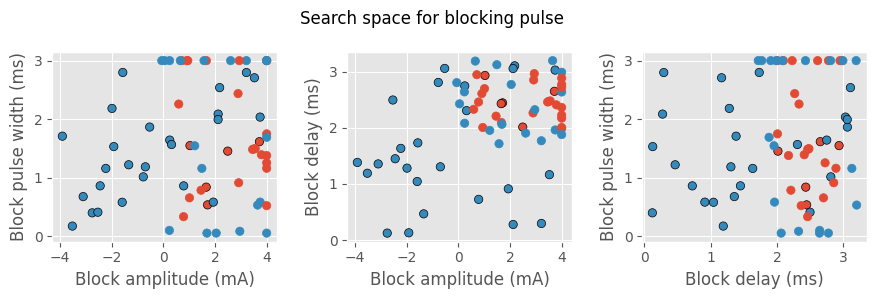

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(9,3))
col_map = {True:'C0',False:'C1'}
edgecolors = [
    'k' if t == 'Initial' else col_map[b] 
    for t, b in zip(df['sample_type'], df['stim_blocked'])
]
colors = [col_map[c] for c in df['stim_blocked']]

ax[0].scatter(df['block_amp'], df['block_pw'], 
              c=colors, 
              edgecolors=edgecolors)
ax[1].scatter(df['block_amp'], df['block_delay'],
              c=colors,
              edgecolors=edgecolors)
ax[2].scatter(df['block_delay'], df['block_pw'],
              c=colors,
              edgecolors=edgecolors)

ax[0].set_xlabel("Block amplitude (mA)")
ax[1].set_xlabel("Block amplitude (mA)")
ax[2].set_xlabel("Block delay (ms)")

ax[0].set_ylabel("Block pulse width (ms)")
ax[1].set_ylabel("Block delay (ms)")
ax[2].set_ylabel("Block pulse width (ms)")

fig.suptitle("Search space for blocking pulse")
fig.tight_layout()

In [160]:
# # Define markers and colors
# markers = {'Initial': 'o', 'Optimization': 's'}
# colors = {True: 'red', False: 'green'}

# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# for sample_type in df['sample_type'].unique():
#     for ap_status in df['stim_blocked'].unique():
#         subset = df[(df['sample_type'] == sample_type) & (df['stim_blocked'] == ap_status)]
#         if not subset.empty:
#             ax.scatter(
#                 subset['block_amp'],
#                 subset['block_pw'],
#                 subset['block_delay'],
#                 c=colors[ap_status],
#                 marker=markers[sample_type],
#                 label=f"{sample_type} - {ap_status}",
#                 alpha=0.7,
#                 edgecolors='w',  # Adds white borders to markers for better visibility
#                 s=60  # Increases marker size for better visibility
#             )

# # Remove duplicate labels in legend
# handles, labels = ax.get_legend_handles_labels()
# unique = dict(zip(labels, handles))
# ax.legend(unique.values(), unique.keys(), title='Sample Type - AP Status', loc='best')

# ax.set_xlabel('Stimulation Amplitude (mA)')
# ax.set_ylabel('Stimulation Pulse Width (ms)')
# ax.set_zlabel('Stimulation Delay (ms)')
# ax.set_title('Amplitude, Pulse Width and Delay vs. AP Block Status')

# plt.tight_layout()
# # Save the figure
# fig.savefig("AP_blocking_optimization.png", dpi=300, bbox_inches='tight')
# plt.show()

In [161]:
df.sort_values(axis=0, by='stim_blocked').head(10)


,block_amp,block_pw,block_delay,sample_type,stim_blocked,stim_generated
0,-2.746055,0.396393,0.123681,Initial,False,True
27,3.526751,2.706774,1.166025,Initial,False,True
28,0.321589,1.565023,2.308163,Initial,False,True
29,-1.586885,0.577084,1.043808,Initial,False,True
30,3.649806,0.529782,3.200000,Optimization,False,True
32,3.749163,0.580224,1.963088,Optimization,False,True
33,1.494022,1.156836,3.127379,Optimization,False,True
40,3.214153,3.000000,1.770749,Optimization,False,True
41,4.000000,0.050000,2.640600,Optimization,False,True
43,1.689303,0.050000,2.063382,Optimization,False,True


In [162]:

top_blocked = df[df['stim_blocked'] & (df['sample_type']=='Optimization')]
top_blocked

,block_amp,block_pw,block_delay,sample_type,stim_blocked,stim_generated
31,3.797473,1.389899,2.410741,Optimization,True,True
34,3.502258,1.488378,2.472901,Optimization,True,True
35,3.457205,1.481466,2.462191,Optimization,True,True
36,3.556418,1.494360,2.481291,Optimization,True,True
37,2.893620,2.436307,2.266747,Optimization,True,True
38,4.000000,3.000000,2.228949,Optimization,True,True
39,1.668977,3.000000,2.096294,Optimization,True,True
42,0.913583,3.000000,2.612417,Optimization,True,True
44,4.000000,3.000000,2.775281,Optimization,True,True
46,0.949172,3.000000,2.007147,Optimization,True,True


## Example of blocking configuration

In [163]:
mrg = create_mrg(diameter=27, length=120, v_init=-80, verbose=True)

# Here we use a fixed stimulation pulse parameters that we want to block
# The stimulation pulse to block start after 1 ms
stim_amp = -1.00 #* mA
stim_pw = 0.50 #* ms
stim_delay = 1.0 #* ms

new_block_params = top_blocked.iloc[0]  # You can also use np.random.choice to pick randomly
#new_block_params = df.iloc[0]

# Assign new values for stimulation blocking
block_amp = new_block_params['block_amp'] * mA 
block_pw = new_block_params['block_pw'] * ms 
block_delay = new_block_params['block_delay'] * ms 

# Create stimuli (a stim and block pulse)
stim = MonophasicPulse(amp=stim_amp, pw=stim_pw, delay=stim_delay)
block = MonophasicPulse(amp=block_amp, pw=block_pw, delay=block_delay)

# Create electrodes at both sides of origin (spacing 60 mm) and 1 mm above the nerve
pointsource_stim = IsotropicPoint(x=0 * mm, y=-30 * mm, z=1 * mm, rhoe=500 * ohm * cm)
pointsource_block = IsotropicPoint(x=0 * mm, y=30 * mm, z=1 * mm, rhoe=500 * ohm * cm)

# Assign stimuli to electrodes
electrode_stim = pointsource_stim << stim
electrode_block = pointsource_block << block

# Set up monitors avoid monitoring the edges to eliminate boundary conditions
ap_monitor_end = APMonitor(mrg.node[-5], threshold= -20 * mV)
ap_monitor_start = APMonitor(mrg.node[5], threshold= -20 * mV)
v_rec = StateMonitor(mrg.node, "v")

# Create the simulation environment
env = SimulationEnvironment(
    axons=[mrg],
    extra_stim=[electrode_stim,
                electrode_block],
    monitors=[
        v_rec,
        ap_monitor_end,
        ap_monitor_start]
)

# Run the simulation for a sufficient duration to observe AP propagation
env.run(runtime = 6 * ms, progressbar=True, early_stopping=False)

Computed number of Nodes: 204
Computed Axon Length: 118.99 mm
Node position of the first node in the axon: x=0.00 mm, y=-59.50 mm, z=0.00 mm
Node position of the last node in the axon: x=0.00 mm, y=59.49 mm, z=0.00 mm


5.5 ms: 100%|██████████| 1200/1200 [00:45<00:00, 26.20it/s]



Simulation Environment:
  # axons: 1
  # extracellular stimulating electrodes: 2
  dt: 0.005 ms

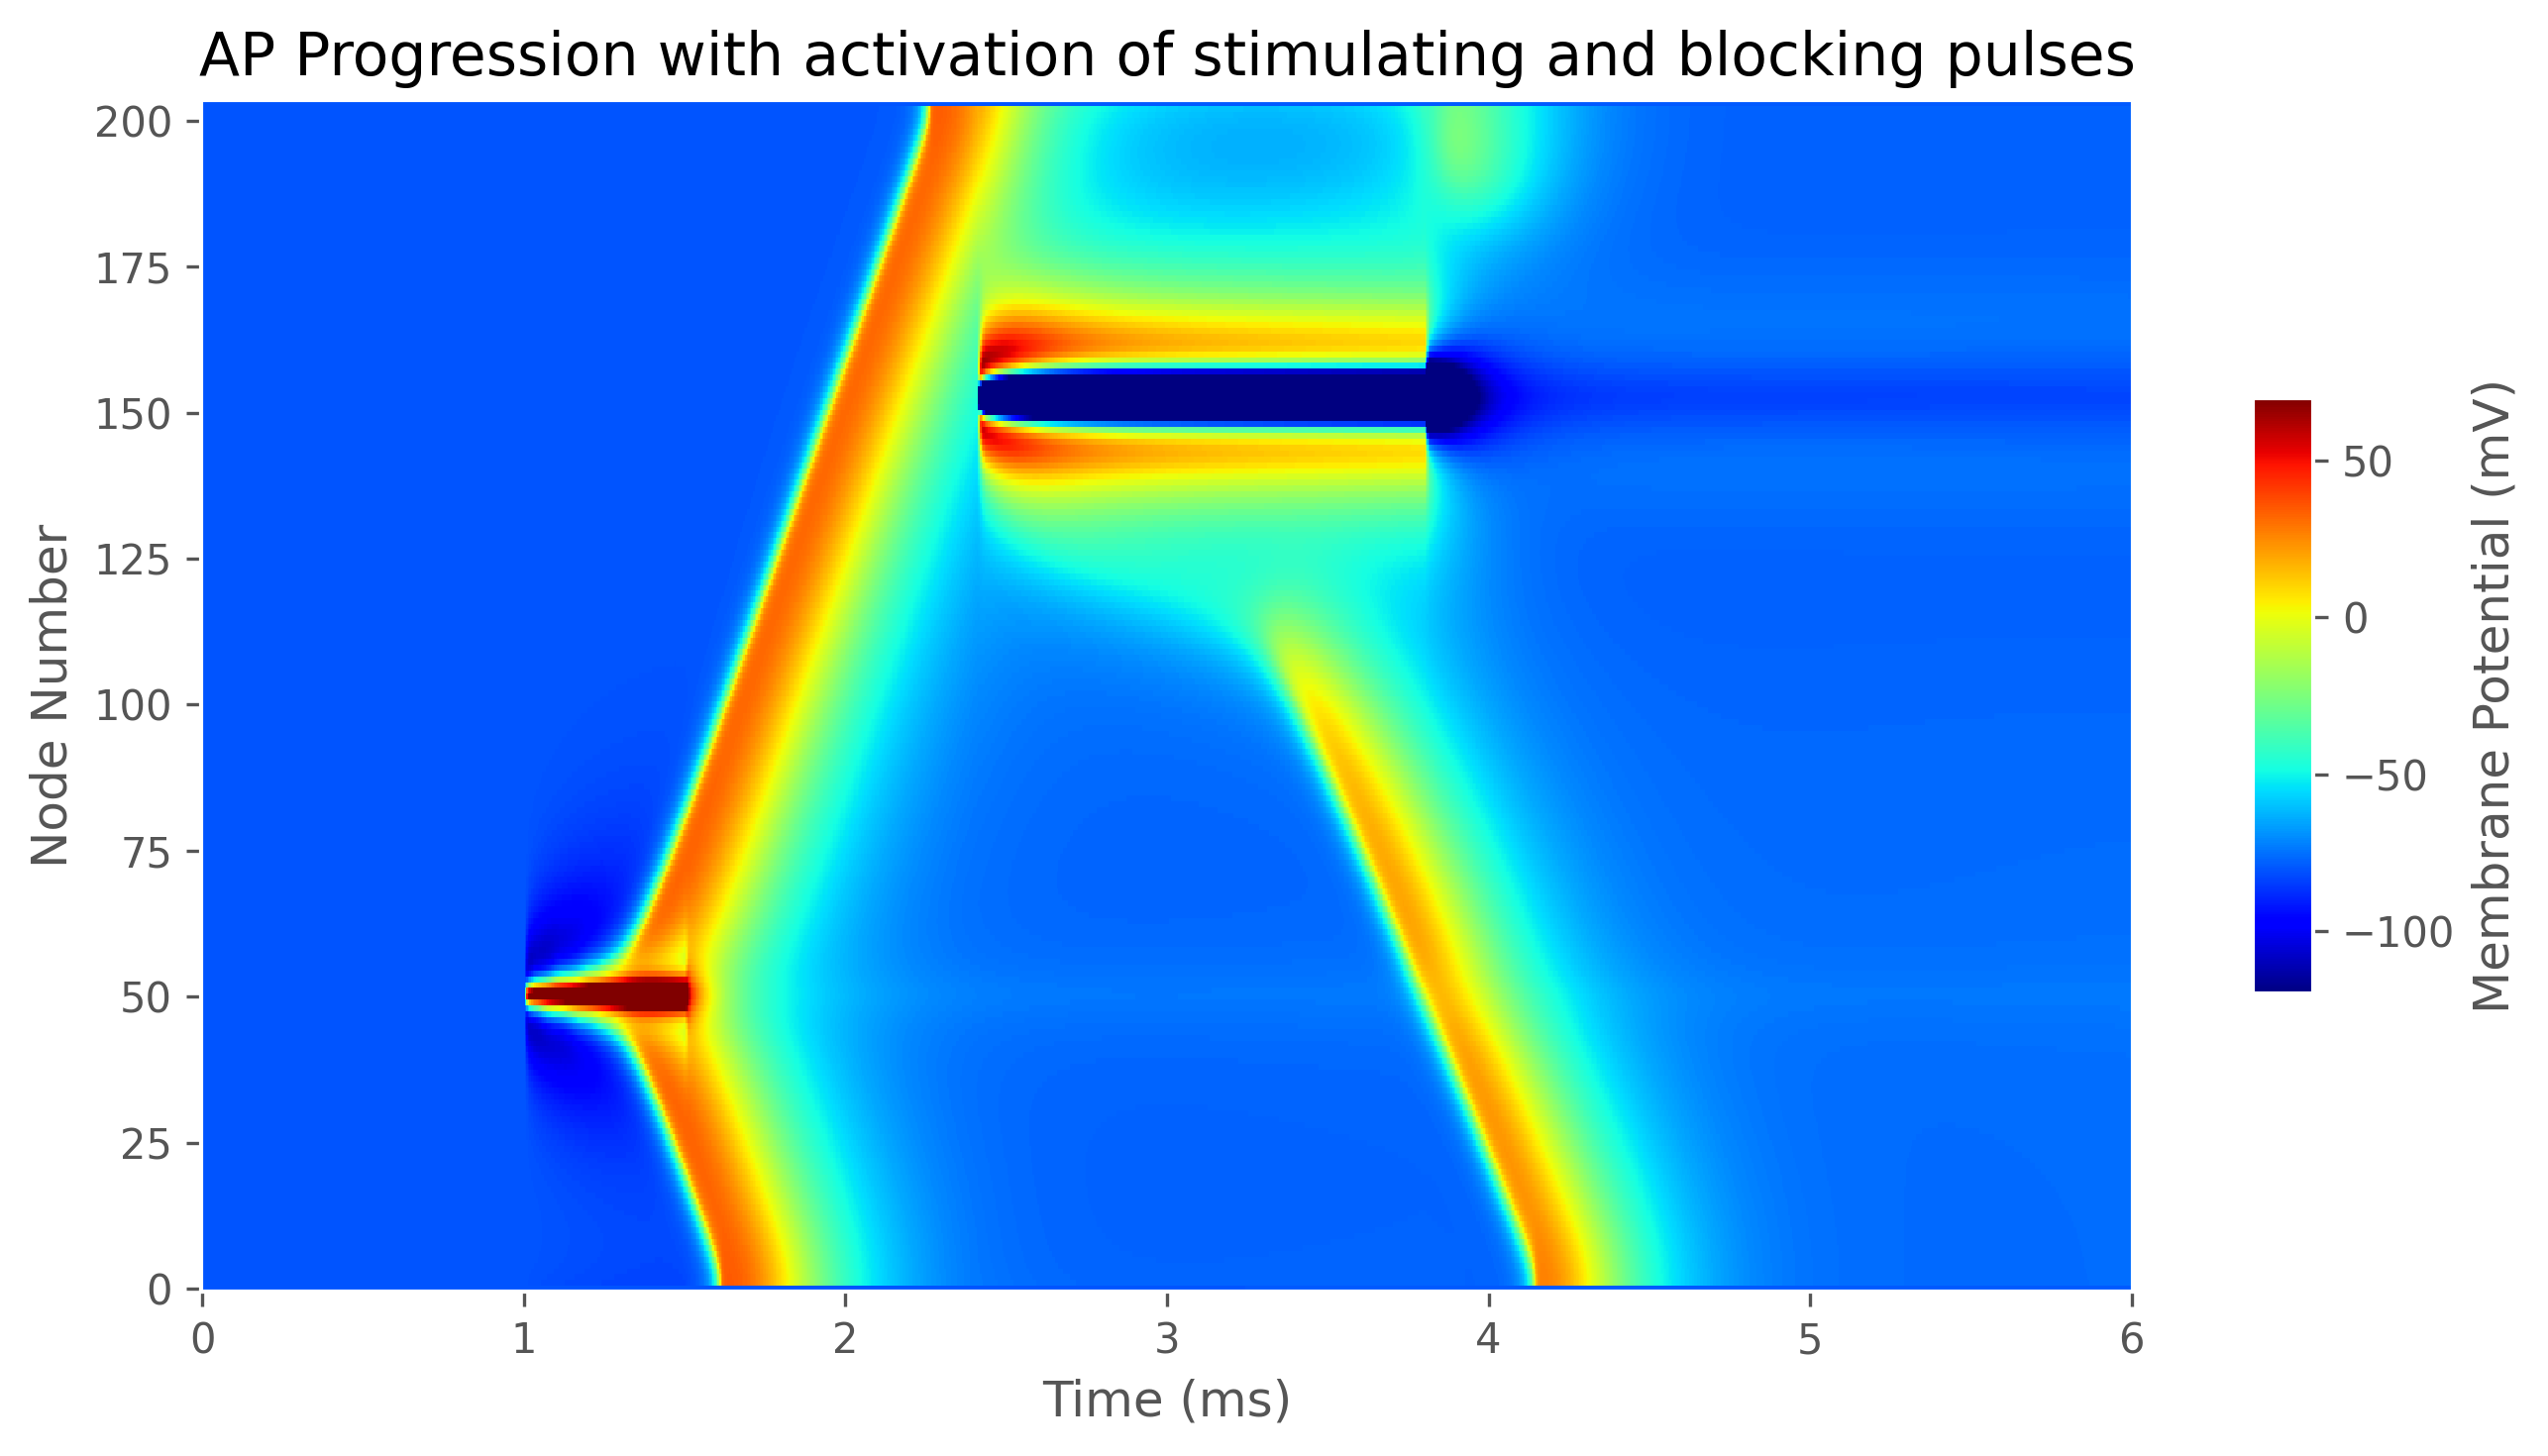

In [164]:
# An example of a blocking the AP prgresses
plot_progression_AP_2D(mrg, v_rec)
fig.tight_layout()

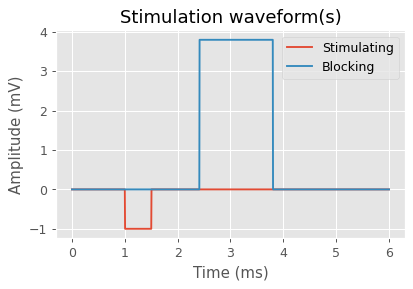

In [165]:
ax = plot_waveform(stim, v_rec, "Stimulating", figsize=(5,3), dpi=90)
_ = plot_waveform(block, v_rec, "Blocking", ax=ax)
fig.tight_layout()

In [166]:
# plt.imshow(v_rec)

In [167]:
v_bool = v_rec.v>-0

In [168]:
nerve_block_condition(ap_monitor_left=ap_monitor_start, ap_monitor_right=ap_monitor_end)

Number of APs between 2.1 ms and 2.9 ms ms at the left side: 0
All spike times at the right side: [2.25]
There is AP on the right side


1

In [169]:
argmin = np.argmin(np.abs(v_rec.t-2.1))
argmax = np.argmin(np.abs(v_rec.t-2.9))
print(v_rec.t[argmin],v_rec.t[argmax])

2.0999999999999663 2.8999999999999493


In [14]:
ap_directional_lines = get_ap_directional(v_bool, min_nodes_for_ap_start=1, y_propagation_threshold=5)
plot_directional_aps(ap_directional_lines=ap_directional_lines, v_bool=v_bool)



NameError: name 'v_bool' is not defined

In [ ]:
detect_block(block_delay, ap_directional_lines=ap_directional_lines,v_rec=v_rec)

1
{'label': 3, 'component_start_time': 314, 'component_end_time': 463, 'upward_line_coords': None, 'downward_line_coords': ((314, 160), (400, 202)), 'y_span_at_start': 3, 'min_y_at_start': 158, 'max_y_at_start': 160}
202 204


{'valid_stim': True, 'stim_generated': True, 'stim_blocked': False}

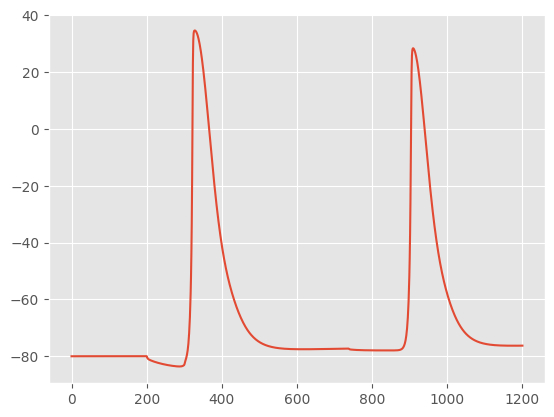

In [ ]:
plt.plot(v_rec.v[1,:])

In [ ]:
ap_directional_lines[min_pos_ix]

{'label': 3,
 'component_start_time': 314,
 'component_end_time': 463,
 'upward_line_coords': None,
 'downward_line_coords': ((314, 160), (400, 202)),
 'y_span_at_start': 3,
 'min_y_at_start': 158,
 'max_y_at_start': 160}

In [ ]:
for e, ap_lines in enumerate(ap_directional_lines):
    print(e)
    if 'downward_line_coords' in ap_lines and ap_lines['downward_line_coords'] is not None:
        print("down", v_rec.t[ap_lines['downward_line_coords'][0][0]])
    if 'upward_line_coords' in ap_lines and ap_lines['upward_line_coords'] is not None:
        print("up", v_rec.t[ap_lines['upward_line_coords'][0][0]])



0
down 1.0099999999999896
up 1.0099999999999896
1
down 1.5699999999999776
2
up 3.7899999999999303


In [ ]:
ap_lines['upward_line_coords']